# Tutorial - evaluate three binary classifiers on a test from the UCI Adult dataset

This tutorial is going to walk through a single evaluation that was carried out on three binary classifiers trained and tested on the UCI Adult dataset. Two algebraic evaluators will be used. The first is the one you may be familiar with - using majority voting to impute the missing answer key to the unlabeled test. The second is hardly known to the ML/AI community - the exact, algebraic solution for error-independent ensembles and the basis of Data Engine's 2010 patent.

![table](../../../img/uciAdultEvalPrevalenceGauges.png)

The gauges above show that, for this particular test, the error-independent algebraic evaluator (AE) gets better estimates than the one obtained using majority voting (assuming the crowd is always right).

When you look at the estimated label accuracies for the three members of the ensemble in this test, the advantages of algebraic evaluation over majority voting become apparent.

![table](../../../img/uciAdultEvalPiaGauges.png)

The majority voting evaluation is terrible. It incorrectly asserts that all three classifiers are worse than average on the "a" label, whereas, in reality, the problematic classifier here is the second one.

This problematic evaluation by majority voting can be traced back to the assumption that underlies using the crowd to impute the missing answer key to any test - the crowd is always right. This not true in general - the classifiers could all be better than random guessers and they would **still** make wrong decisions as a group.

## Walking through estimating the label prevalences in the test

In [1]:
from pprint import pprint, pp
import ntqr

There are data sketches available for 3 Neural Networks classifying the UCI Adult dataset

In [2]:
from ntqr.r2.uci_adult_20240415 import data_sketches
len(data_sketches)

100

In [3]:
# We know run 93 was particularly good
labeled_counts = data_sketches[93]
pprint(labeled_counts)

{'a': {('a', 'a', 'a'): 943,
       ('a', 'a', 'b'): 393,
       ('a', 'b', 'a'): 198,
       ('a', 'b', 'b'): 62,
       ('b', 'a', 'a'): 306,
       ('b', 'a', 'b'): 124,
       ('b', 'b', 'a'): 52,
       ('b', 'b', 'b'): 29},
 'b': {('a', 'a', 'a'): 774,
       ('a', 'a', 'b'): 1585,
       ('a', 'b', 'a'): 1611,
       ('a', 'b', 'b'): 3505,
       ('b', 'a', 'a'): 1270,
       ('b', 'a', 'b'): 2876,
       ('b', 'b', 'a'): 2661,
       ('b', 'b', 'b'): 5984}}


In an unsupervised setting, we do not know the true label for any item. All we get to see are the decisions the classifiers made. These are in effect, the sum of the above counts across the different labels. There is a class for operating on the labeled counts that can give us the projected counts.

In [4]:
trio_labeled_counts = ntqr.TrioLabelVoteCounts(labeled_counts)
pprint(trio_labeled_counts)

TrioLabelVoteCounts(label_vote_counts={'a': {('a', 'a', 'a'): 943,
                                             ('a', 'a', 'b'): 393,
                                             ('a', 'b', 'a'): 198,
                                             ('a', 'b', 'b'): 62,
                                             ('b', 'a', 'a'): 306,
                                             ('b', 'a', 'b'): 124,
                                             ('b', 'b', 'a'): 52,
                                             ('b', 'b', 'b'): 29},
                                       'b': {('a', 'a', 'a'): 774,
                                             ('a', 'a', 'b'): 1585,
                                             ('a', 'b', 'a'): 1611,
                                             ('a', 'b', 'b'): 3505,
                                             ('b', 'a', 'a'): 1270,
                                             ('b', 'a', 'b'): 2876,
                                             ('b', 'b', 'a'

The class TrioLabelVoteCounts can project the counts across labels for us and give us only the vote pattern counts.

In [5]:
trio_vote_counts = trio_labeled_counts.to_TrioVoteCounts()
pprint(trio_vote_counts)

TrioVoteCounts(vote_counts={('a', 'a', 'a'): 1717,
                            ('a', 'a', 'b'): 1978,
                            ('a', 'b', 'a'): 1809,
                            ('a', 'b', 'b'): 3567,
                            ('b', 'a', 'a'): 1576,
                            ('b', 'a', 'b'): 3000,
                            ('b', 'b', 'a'): 2713,
                            ('b', 'b', 'b'): 6013})


The challenge in unsupervised evaluation is to go from these counts back to the by-label counts. Let's see what happens when you use an algebraic evaluation that assumes that the classifiers were error independent on this test.

In [6]:
algebraic_eval = ntqr.ErrorIndependentEvaluation(trio_vote_counts)

In [7]:
ae_eval = algebraic_eval.evaluation_exact
pprint(ae_eval[0]["prevalence"])

{'a': 1/2 - 65278688621*sqrt(12926495728977)/578408977888804842,
 'b': 65278688621*sqrt(12926495728977)/578408977888804842 + 1/2}


The two possible solutions for the 'a' label prevalence contain an unresolved square root. This means that the error independence assumption is wrong! The three classifiers in the test have non-zero error correlations. But let us see how close this irrational number is to the actual value.

In [8]:
ae_evalf = algebraic_eval.evaluation_float
pprint(ae_evalf[0]["prevalence"])

{'a': 0.09423292951169045, 'b': 0.9057670704883095}


The correct evaluation can be computed with the labeled counts.

In [9]:
supervised_eval = ntqr.SupervisedEvaluation(trio_labeled_counts)
seval_exact = supervised_eval.evaluation_exact
seval_float = supervised_eval.evaluation_float

In [10]:
seval_float["prevalence"]

{'a': 0.0941760157332499, 'b': 0.9058239842667501}

So the error independent estimate is 9.423% and the true 'a' label prevalence is 9.418%. Really good. But sometimes it veers. We'll show that later. Let's continue with this data sketch to see what Majority Voting estimates.

In [11]:
majority_voting_eval = ntqr.MajorityVotingEvaluation(trio_vote_counts)
mv_eval_exact = majority_voting_eval.evaluation_exact
mv_eval_float = majority_voting_eval.evaluation_float

Majority voting does not warn you that the classifiers are actually error correlated since it can only produce rational estimates.

In [12]:
mv_eval_exact[0]["prevalence"]

{'a': Fraction(7080, 22373), 'b': Fraction(15293, 22373)}

In [13]:
mv_eval_float[0]["prevalence"]

{'a': 0.31645286729540073, 'b': 0.6835471327045993}

To summarize - the true 'a' label prevalence is 9.4%, algebraic evaluation estimates 9.4%, and majority voting 31.6%

## The label accuracies

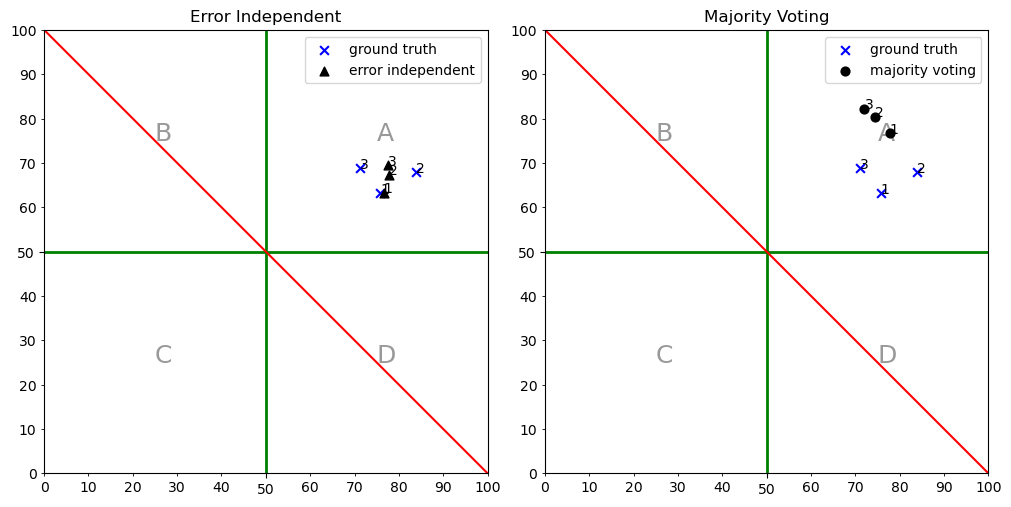

In [14]:
%matplotlib inline
from ntqr.r2.plots import compare_evaluations, plot_evaluations
mv_exact = majority_voting_eval.evaluation_exact
size=40
compare_evaluations([
    ["ground truth", 
     [d['a']*100 for d in seval_exact["accuracy"]],
     [d['b']*100 for d in seval_exact["accuracy"]],
      "x","b",size],
    ["error independent",
     [d['a']*100 for d in ae_eval[0]["accuracy"]],
     [d['b']*100 for d in ae_eval[0]["accuracy"]],
      "^", "k",size],
    ["majority voting",
     [d['a']*100 for d in mv_eval_exact[0]["accuracy"]],
     [d['b']*100 for d in mv_eval_exact[0]["accuracy"]],
      "o", "k",size],],0,
    titles=["Ground Truth","Error Independent", "Majority Voting"],figsize=(10,5),legend_loc="best",withArrows=False)

The results for the error-independent solution are better than majority voting. But let's take a look 

## Histogram of data sketch evaluations

Let's take a look at the prevalence estimates for these data sketches. The ground truth for the 'a' label is 9.2%.

In [15]:
# Let's collect all the evaluations using the error-independent evaluator
ae_estimates = [ntqr.ErrorIndependentEvaluation(ntqr.TrioLabelVoteCounts(ds).to_TrioVoteCounts()) for ds in data_sketches]
# And the majority voting estimates also
mv_estimates = [ntqr.MajorityVotingEvaluation(ntqr.TrioLabelVoteCounts(ds).to_TrioVoteCounts()) for ds in data_sketches]

In [16]:
import matplotlib.pyplot as plt
# We are picking out the lowest prevalence solution for the 'a' label
prev_ae_estimates = [float(eval.evaluation_exact[0]["prevalence"]["a"]) for eval in ae_estimates]
prev_mv_estimates = [float(eval.evaluation_exact[0]["prevalence"]["a"]) for eval in mv_estimates]

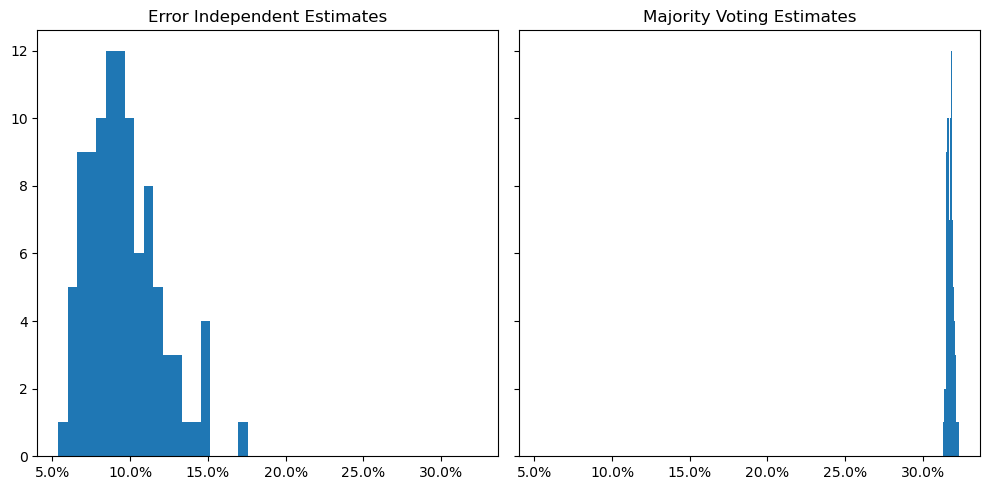

In [17]:
%matplotlib inline
from matplotlib.ticker import PercentFormatter
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, tight_layout=True,figsize=(10,5))
n_bins = 20
axs[0].hist(prev_ae_estimates, bins=n_bins)
axs[0].set_title("Error Independent Estimates")
axs[1].xaxis.set_major_formatter(PercentFormatter(xmax=1))
axs[1].hist(prev_mv_estimates, bins=n_bins)
axs[1].set_title("Majority Voting Estimates")
plt.show()
